<a href="https://colab.research.google.com/github/anbhu181/project/blob/main/project_phase2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install implicit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 49.0 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import NearestNeighbors
from datetime import datetime
import implicit
from scipy.sparse import coo_matrix
import warnings
warnings.filterwarnings("ignore")

In [8]:
# 1. Load data
movies = pd.read_csv("/content/movies.csv")
ratings = pd.read_csv("/content/ratings.csv")
tags = pd.read_csv("/content/tags.csv")
links = pd.read_csv("/content/links.csv")
print(movies)
print(ratings)
print(tags)
print(links)

      movieId                                      title  \
0           1                           Toy Story (1995)   
1           2                             Jumanji (1995)   
2           3                    Grumpier Old Men (1995)   
3           4                   Waiting to Exhale (1995)   
4           5         Father of the Bride Part II (1995)   
...       ...                                        ...   
9737   193581  Black Butler: Book of the Atlantic (2017)   
9738   193583               No Game No Life: Zero (2017)   
9739   193585                               Flint (2017)   
9740   193587        Bungo Stray Dogs: Dead Apple (2018)   
9741   193609        Andrew Dice Clay: Dice Rules (1991)   

                                           genres  
0     Adventure|Animation|Children|Comedy|Fantasy  
1                      Adventure|Children|Fantasy  
2                                  Comedy|Romance  
3                            Comedy|Drama|Romance  
4                  

In [9]:
# 2. Merge and clean data
tags['tag'] = tags['tag'].astype(str)
tags_grouped = tags.groupby(['userId', 'movieId'])['tag'].apply(lambda x: ', '.join(x)).reset_index()
df = ratings.merge(movies, on='movieId').merge(tags_grouped, on=['userId', 'movieId'], how='left')
df = df.merge(links, on='movieId', how='left')
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
print("Merged Data Sample:")
print(df.head())

Merged Data Sample:
   userId  movieId  rating           timestamp                        title  \
0       1        1     4.0 2000-07-30 18:45:03             Toy Story (1995)   
1       1        3     4.0 2000-07-30 18:20:47      Grumpier Old Men (1995)   
2       1        6     4.0 2000-07-30 18:37:04                  Heat (1995)   
3       1       47     5.0 2000-07-30 19:03:35  Seven (a.k.a. Se7en) (1995)   
4       1       50     5.0 2000-07-30 18:48:51   Usual Suspects, The (1995)   

                                        genres  tag  imdbId   tmdbId  
0  Adventure|Animation|Children|Comedy|Fantasy  NaN  114709    862.0  
1                               Comedy|Romance  NaN  113228  15602.0  
2                        Action|Crime|Thriller  NaN  113277    949.0  
3                             Mystery|Thriller  NaN  114369    807.0  
4                       Crime|Mystery|Thriller  NaN  114814    629.0  


In [10]:
# 3. Clean genres
df['genres'] = df['genres'].apply(lambda x: x.split('|') if isinstance(x, str) else [])
print(df['genres'])

0         [Adventure, Animation, Children, Comedy, Fantasy]
1                                         [Comedy, Romance]
2                                 [Action, Crime, Thriller]
3                                       [Mystery, Thriller]
4                                [Crime, Mystery, Thriller]
                                ...                        
100831                            [Drama, Horror, Thriller]
100832                            [Action, Crime, Thriller]
100833                                             [Horror]
100834                                     [Action, Sci-Fi]
100835                     [Action, Crime, Drama, Thriller]
Name: genres, Length: 100836, dtype: object


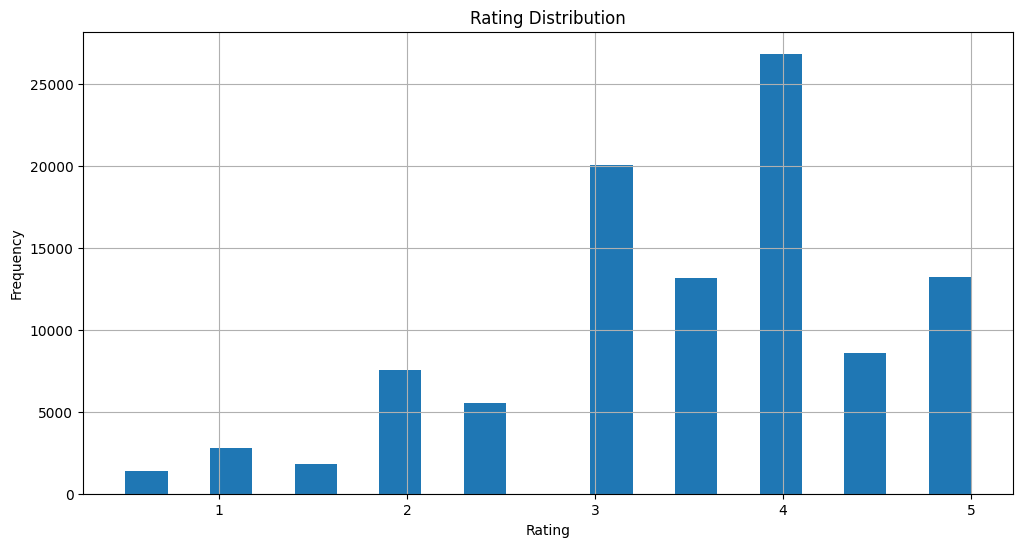

In [11]:
# 4. EDA
plt.figure(figsize=(12,6))
df['rating'].hist(bins=20)
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

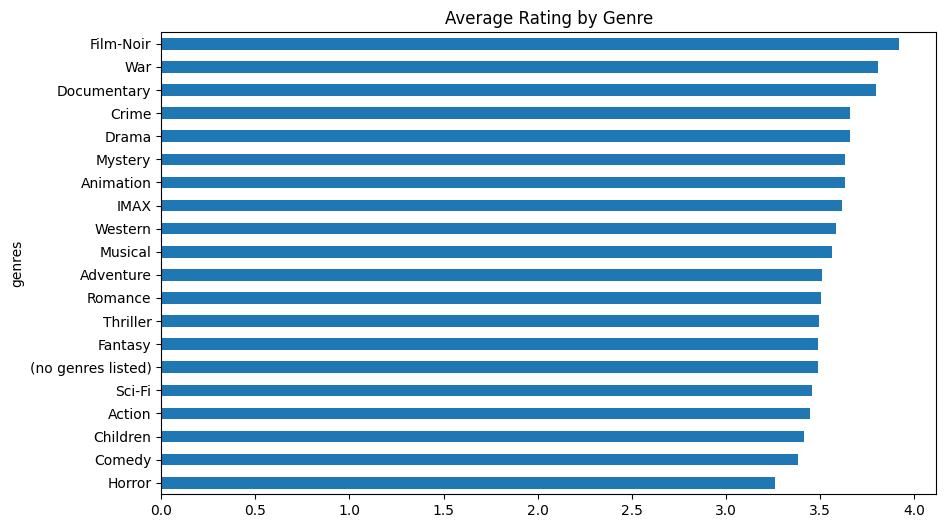

In [12]:
# Trend by genre
genre_count = df.explode('genres').groupby('genres')['rating'].mean().sort_values()
genre_count.plot(kind='barh', figsize=(10,6), title='Average Rating by Genre')
plt.show()

In [13]:
# 5. Feature Engineering - encode genres
mlb = MultiLabelBinarizer()
genre_encoded = mlb.fit_transform(df['genres'])
genre_df = pd.DataFrame(genre_encoded, columns=mlb.classes_)
print(genre_df)

        (no genres listed)  Action  Adventure  Animation  Children  Comedy  \
0                        0       0          1          1         1       1   
1                        0       0          0          0         0       1   
2                        0       1          0          0         0       0   
3                        0       0          0          0         0       0   
4                        0       0          0          0         0       0   
...                    ...     ...        ...        ...       ...     ...   
100831                   0       0          0          0         0       0   
100832                   0       1          0          0         0       0   
100833                   0       0          0          0         0       0   
100834                   0       1          0          0         0       0   
100835                   0       1          0          0         0       0   

        Crime  Documentary  Drama  Fantasy  Film-Noir  Horror  

In [14]:
# 6. Create user-item matrix
user_item_matrix = df.pivot_table(index='userId', columns='movieId', values='rating').fillna(0)
print("User-Item Matrix Sample:")
print(user_item_matrix.iloc[:5, :5])

User-Item Matrix Sample:
movieId    1    2    3    4    5
userId                          
1        4.0  0.0  4.0  0.0  0.0
2        0.0  0.0  0.0  0.0  0.0
3        0.0  0.0  0.0  0.0  0.0
4        0.0  0.0  0.0  0.0  0.0
5        4.0  0.0  0.0  0.0  0.0


In [15]:
# Matrix factorization (SVD for content-based user profile)
svd = TruncatedSVD(n_components=20)
user_factors = svd.fit_transform(user_item_matrix)
movie_factors = svd.components_.T
print("User Factors Sample:")
print(user_factors[:5])
print("Movie Factors Sample:")
print(movie_factors[:5])

User Factors Sample:
[[ 29.68924409 -14.2611816    2.08249392  -0.14017198  14.24074015
    7.72915426   0.71062726  -1.00917633   3.97423434   2.54180048
    5.62413877  -1.85966611   3.05017348  -0.26462906  -6.83712355
    3.5335151    4.47592762  -2.79401471   3.94190851   4.00451199]
 [  3.13506492   4.10160742   0.84541737   2.27382605  -0.23103499
   -2.27613699   0.88653086   0.9200343    2.48311704   1.73761953
    0.75487688  -1.75649412   0.82296159   2.45417386  -0.97804849
   -0.63951266  -0.45752399   1.04134837  -0.24932282   0.26109888]
 [  0.72319333  -0.47833685  -0.32786363  -0.33415827   1.14205941
   -0.03030698   0.20186637   0.05313806  -0.25925236  -0.08157617
    0.46248916   0.212424     0.35638698   0.55127583  -0.12186954
    0.73507729   0.15529808  -0.26762511   0.58581249  -0.73519634]
 [ 17.29491237 -12.54010883  -6.53049881   6.23716716  -2.14142172
    1.06942375   5.35014725  -5.2648179    5.04414815  -3.05414301
    0.28773416   2.75400072  -6.445251

In [16]:
# 7. ALS - implicit library requires item-user sparse matrix
sparse_item_user = coo_matrix(user_item_matrix.T)
model_als = implicit.als.AlternatingLeastSquares(factors=20, iterations=10)
model_als.fit(sparse_item_user)

  0%|          | 0/10 [00:00<?, ?it/s]

In [17]:
# 8. KNN for content-based filtering
knn = NearestNeighbors(metric='cosine', algorithm='brute')
knn.fit(movie_factors)

NearestNeighbors(algorithm='brute', metric='cosine')

In [18]:
def recommend(user_id, n=10):
    user_vector = user_factors[user_id - 1]  # Adjust for 0-index
    print(f"User vector for user {user_id}:")
    print(user_vector)
    _, indices = knn.kneighbors([user_vector], n_neighbors=n)
    movie_ids = user_item_matrix.columns[indices[0]]
    print(f"Recommended movie IDs for user {user_id}: {list(movie_ids)}")
    recommended_movies = movies[movies['movieId'].isin(movie_ids)]
    return recommended_movies # Return the DataFrame

# Call recommend and assign the result to a variable
recommended_movies_result = recommend(user_id=1)

# Now you can print the result
print(recommended_movies_result)

User vector for user 1:
[ 29.68924409 -14.2611816    2.08249392  -0.14017198  14.24074015
   7.72915426   0.71062726  -1.00917633   3.97423434   2.54180048
   5.62413877  -1.85966611   3.05017348  -0.26462906  -6.83712355
   3.5335151    4.47592762  -2.79401471   3.94190851   4.00451199]
Recommended movie IDs for user 1: [2987, 2791, 1391, 1036, 2115, 1377, 1196, 2918, 2640, 2985]
      movieId                                              title  \
793      1036                                    Die Hard (1988)   
898      1196  Star Wars: Episode V - The Empire Strikes Back...   
1060     1377                              Batman Returns (1992)   
1071     1391                               Mars Attacks! (1996)   
1576     2115        Indiana Jones and the Temple of Doom (1984)   
1986     2640                                    Superman (1978)   
2097     2791                                   Airplane! (1980)   
2195     2918                    Ferris Bueller's Day Off (1986)   
2248

In [19]:
# 9. Evaluation (offline)
def precision_at_k(actual, predicted, k):
    actual_set = set(actual)
    predicted = predicted[:k]
    return len(set(predicted) & actual_set) / k

In [20]:
# Evaluate precision@5
actual_movies = df[df['userId'] == 1].sort_values(by='rating', ascending=False)['movieId'].tolist()
recs = recommend(user_id=1) # Call the recommend function and store the result in 'recs'
predicted_movies = recs['movieId'].tolist()
print(f"Precision@5 for user 1: {precision_at_k(actual_movies, predicted_movies, 5):.2f}")

User vector for user 1:
[ 29.68924409 -14.2611816    2.08249392  -0.14017198  14.24074015
   7.72915426   0.71062726  -1.00917633   3.97423434   2.54180048
   5.62413877  -1.85966611   3.05017348  -0.26462906  -6.83712355
   3.5335151    4.47592762  -2.79401471   3.94190851   4.00451199]
Recommended movie IDs for user 1: [2987, 2791, 1391, 1036, 2115, 1377, 1196, 2918, 2640, 2985]
Precision@5 for user 1: 0.60


In [21]:
# 10. Simple UI (print recommendations for a user)
print("Top recommendations for user 1:")
print(recommend(user_id=1))

Top recommendations for user 1:
User vector for user 1:
[ 29.68924409 -14.2611816    2.08249392  -0.14017198  14.24074015
   7.72915426   0.71062726  -1.00917633   3.97423434   2.54180048
   5.62413877  -1.85966611   3.05017348  -0.26462906  -6.83712355
   3.5335151    4.47592762  -2.79401471   3.94190851   4.00451199]
Recommended movie IDs for user 1: [2987, 2791, 1391, 1036, 2115, 1377, 1196, 2918, 2640, 2985]
      movieId                                              title  \
793      1036                                    Die Hard (1988)   
898      1196  Star Wars: Episode V - The Empire Strikes Back...   
1060     1377                              Batman Returns (1992)   
1071     1391                               Mars Attacks! (1996)   
1576     2115        Indiana Jones and the Temple of Doom (1984)   
1986     2640                                    Superman (1978)   
2097     2791                                   Airplane! (1980)   
2195     2918                    Ferris 